# FinOpt — Simulation & Optimization Demo

This notebook showcases the **current MVP** of FinOpt:

- Income modeling → monthly contributions
- Three-case deterministic scenarios (base/optimistic/pessimistic)
- Monte Carlo simulation (IID lognormal)
- Optimization solvers: minimum contribution (closed-form), minimum time (binary search)
- Goal evaluation & chance-constraints
- (Bonus) Multi-asset portfolio simulation


## 0) Setup

In [1]:
# --- Path setup: add project root so "src" is importable ---
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# --- Standard libs ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

# --- FinOpt modules (desde /src) ---
from src.income import FixedIncome, VariableIncome, IncomeModel
from src.investment import (
    simulate_capital, simulate_portfolio
)
from src.scenario import ScenarioConfig, SimulationEngine, plot_scenario, plot_scenarios
from src.goals import Goal, evaluate_goals
from src.utils import summary_metrics


## 1) Income model → contributions

In [2]:
seasonality_norm = [
    0.00,  # Jan
    0.00,  # Feb
    0.00,  # Mar
    1.32,  # Apr
    1.48,  # May
    1.36,  # Jun
    1.24,  # Jul
    1.18,  # Aug
    0.87,  # Sep (reducido)
    1.16,  # Oct
    1.28,  # Nov
    1.31,  # Dec
]

income = IncomeModel(
    fixed=FixedIncome(base=1_400_000.0, annual_growth=0.10),
    variable=VariableIncome(
        base=150_000.0,
        seasonality=seasonality_norm,
        sigma=0.10,         # 10% de ruido mensual
        floor=50_000.0,     # piso mínimo
        cap=400_000.0,      # techo máximo
        annual_growth=0.02,
        seed=42
    ),
)

months = 24
start = date(2025, 9, 1)

# Proportional contribution rule: 35% of fixed + 100% of variable
alpha, beta = 0.35, 1.0
contributions = income.contributions(months=months, alpha_fixed=alpha, beta_variable=beta, start=start)
contributions.head()

2025-09-01    624476.557891
2025-10-01    650069.093950
2025-11-01    704936.842570
2025-12-01    717864.745764
2026-01-01    555817.256574
Freq: MS, Name: contribution, dtype: float64

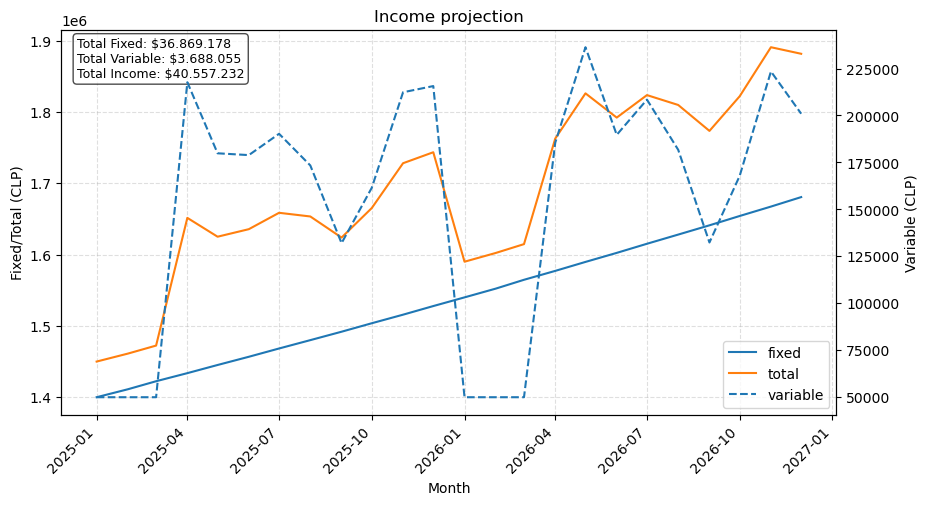

In [3]:
income.plot(months=24, start=date(2025, 1, 1), kind="lines", dual_axis=True,
            title="Income projection")

In [4]:
# Summary for 24 months
summary_24m = income.summary(months=24, start=date(2025, 9, 1))
print("=== Summary (24 months) ===")
print(summary_24m)

=== Summary (24 months) ===
months                    24.00
total_income        40635230.46
total_fixed         36869177.64
total_variable       3766052.82
mean_total           1693134.60
mean_fixed           1536215.74
mean_variable         156918.87
fixed_share                0.91
variable_share             0.09
std_variable           67157.35
coefvar_variable           0.43
dtype: float64


## 2) Build Scenario

In [5]:
# Configuración de escenario (24 meses)
cfg = ScenarioConfig(
    months=24,
    start=date(2025, 9, 1),
    alpha_fixed=0.35,
    beta_variable=1.0,
    base_r=0.004,        # 0.4% mensual
    optimistic_r=0.007,
    pessimistic_r=0.001,
)

sim = SimulationEngine(income, cfg)

results = sim.run_three_cases()

# Mostrar métricas comparativas
summary_metrics(results)


,final_wealth,total_contributions,cagr,vol,max_drawdown
scenario,,,,,
base,1.750304e+07,1.667026e+07,4.283622,0.223508,0.0
optimistic,1.816160e+07,1.667026e+07,4.374082,0.223827,0.0
pessimistic,1.687376e+07,1.667026e+07,4.195542,0.223182,0.0


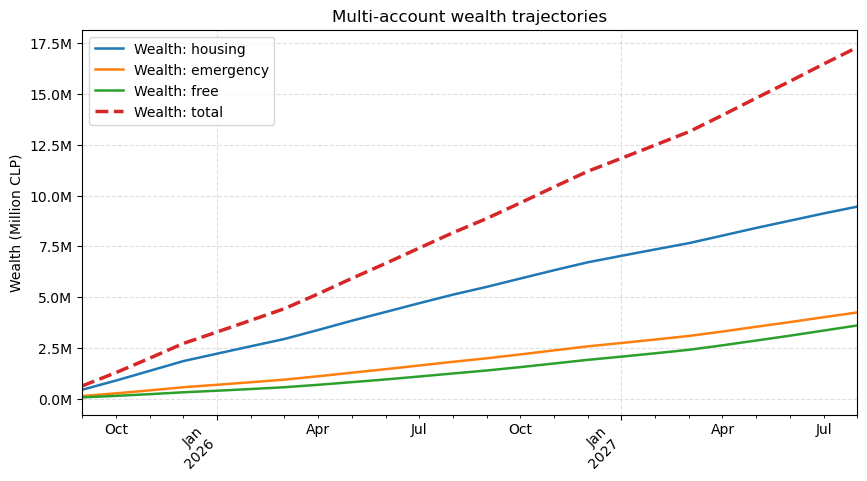

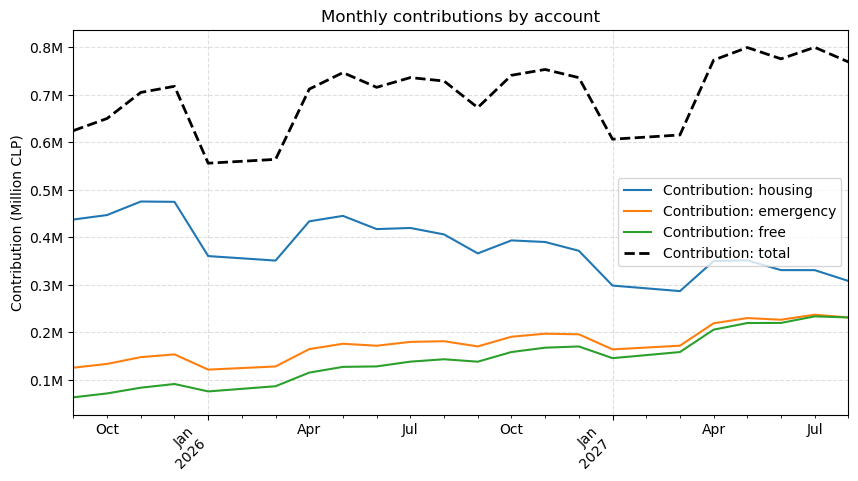

(<Figure size 1000x500 with 1 Axes>,
 (<Axes: title={'center': 'Multi-account wealth trajectories'}, ylabel='Wealth (Million CLP)'>,
  <Axes: title={'center': 'Monthly contributions by account'}, ylabel='Contribution (Million CLP)'>))

In [6]:
from src.scenario import ScenarioConfig, SimulationEngine
from src.utils import fixed_rate_path

cfg = ScenarioConfig(months=24, start=date(2025, 9, 1), alpha_fixed=0.35, beta_variable=1.0)
eng = SimulationEngine(income, cfg, accounts=["housing", "emergency", "free"])

# Ejemplo C(t,k): glidepath lineal
idx = eng._index()
T = len(idx)
w0 = [0.70, 0.20, 0.10]
wT = [0.40, 0.30, 0.30]
glide = np.linspace(0.0, 1.0, T)[:, None]
C = (1 - glide) * np.array(w0) + glide * np.array(wT)

# Retornos por cuenta
r_housing   = fixed_rate_path(T, 0.003)
r_emergency = fixed_rate_path(T, 0.001)
r_free      = fixed_rate_path(T, 0.006)
R = np.column_stack([r_housing, r_emergency, r_free])

res = eng.run_case_named(
    "glide",
    C_matrix=C,                 # (T,K)
    returns_by_account=R,       # (T,K)
)

res.wealth_by_account.tail()
plot_scenario(res)

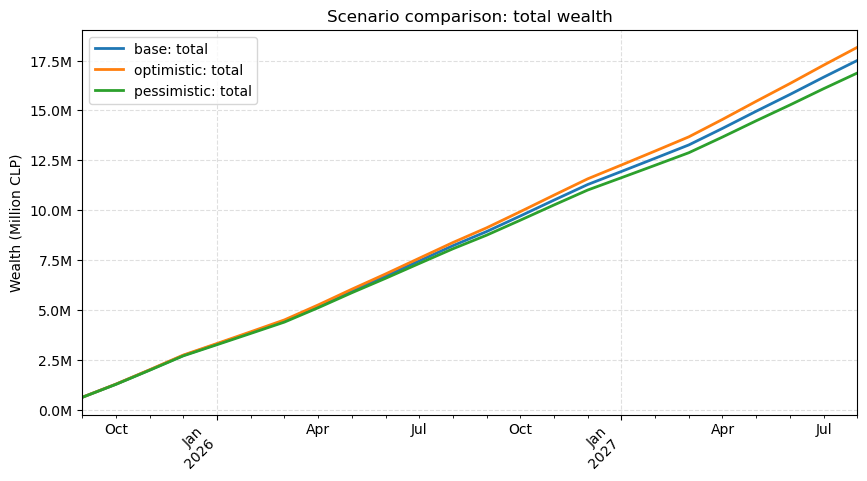

In [7]:
res_base = eng.run_case_named("base", C_matrix=C, returns_by_account=0.004)
res_opt  = eng.run_case_named("optimistic", C_matrix=C, returns_by_account=0.007)
res_pes  = eng.run_case_named("pessimistic", C_matrix=C, returns_by_account=0.001)

from src.scenario import plot_scenarios
plot_scenarios({"base": res_base, "optimistic": res_opt, "pessimistic": res_pes});
